In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 16}) 

import numpy as np

In [2]:
import tqdm

In [3]:
from scipy.interpolate import InterpolatedUnivariateSpline as IUS
import phenom

import lal
import lalsimulation as lalsim

from scrinet.interfaces import lalutils

In [4]:
from scrinet.greedy import greedyrb
from scrinet.surrogate import surrogate

# Data acquisition

We need a function that we can call to
generate data in a uniform way.

We will use this to generate the data for:
 - the seed basis
 - additional training sets and
 - validation sets

In [5]:
def gen_1d_massratio_data(q_array, M, deltaT=1/1024., f_min=10,
                         approximant=lalsim.SEOBNRv4_opt, inclination=0,
                          t_min=-10000, t_max=100, npts=5000
                         ):

    new_times = np.linspace(t_min, t_max, npts)
    
    data = []
    coords = []
    
    for q in q_array:
        m1, m2 = phenom.m1_m2_M_q(M, q)
        pp = dict(m1=m1, m2=m2, deltaT=deltaT,
                  f_min=f_min,
                  inclination=inclination,
                  approximant=approximant
                 )
        p = lalutils.gen_td_wf_params(**pp)
        t, amp, phase = lalutils.gen_td_wf(p, t_min=t_min, t_max=t_max)
              
        iamp = IUS(t, amp)
        iphase = IUS(t, phase)
        
        amp = iamp(new_times)
        phase = iphase(new_times)
        
        tshift = lalutils.peak_align_shift(new_times, amp)
        amp = lalutils.peak_align_interp(new_times, amp, tshift)
        phase = lalutils.peak_align_interp(new_times, phase, tshift)
        
        d = {"t":new_times, "amp":amp, "phase":phase}
        
        data.append(d)
        coords.append([q])
    
    n_t_points = len(new_times)
    n_waveforms = len(data)
    ts_amp = np.zeros(shape=(n_waveforms, n_t_points))
    ts_phase = np.zeros(shape=(n_waveforms, n_t_points))
    
    
    
    for i in range(n_waveforms):
        ts_amp[i] = data[i]['amp'] / phenom.eta_from_q(coords[i][0]) / 1e5
        ts_phase[i] = data[i]['phase'] - data[i]['phase'][0]
        
    return new_times, ts_amp, ts_phase, np.array(coords)

In [6]:
seed_x, seed_ts_amp, seed_ts_phase, seed_ts_coords = gen_1d_massratio_data(np.linspace(1,10,3), 60) 

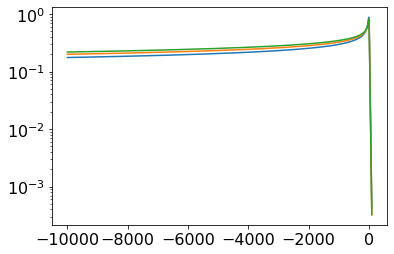

In [7]:
plt.figure()
for i in range(len(seed_ts_amp)):
#     plt.plot(seed_x, seed_ts_amp[i] / phenom.eta_from_q(seed_ts_coords[i]))
    plt.plot(seed_x, seed_ts_amp[i])
plt.yscale('log')

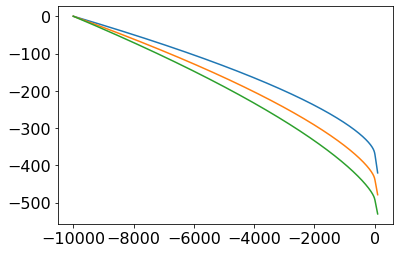

In [8]:
plt.figure()
for i in range(len(seed_ts_amp)):
    plt.plot(seed_x, seed_ts_phase[i])

# run

In [9]:
# Make integration rule

int_range = [seed_x[0], seed_x[-1]]
int_num = len(seed_x)

integration = greedyrb.Riemann(int_range, num=int_num)
x = integration.nodes  # Define x for convenience

In [10]:
sur = surrogate.Surrogate(integration) 

In [11]:
sur.build_seed_basis(ts=seed_ts_amp, ts_coords=seed_ts_coords) 

building seed basis


In [12]:
sur.grb.greedy_points 

array([[ 1. ],
       [ 5.5],
       [10. ]])

In [13]:
# check seed basis and add points
_, ts_amp, _, ts_coords = gen_1d_massratio_data(np.random.uniform(1,10,10), 60) 

In [14]:
sur.run_greedy_sweep(ts_amp, ts_coords, verbose=True, greedy_tol=1e-3) 

tolerance reached. exiting


In [15]:
# build eim
# eim needs to be built from training_set at the greedy points
_, ts, _, _ = gen_1d_massratio_data(sur.grb.greedy_points.ravel(), 60)

In [16]:
sur.build_eim(ts) 

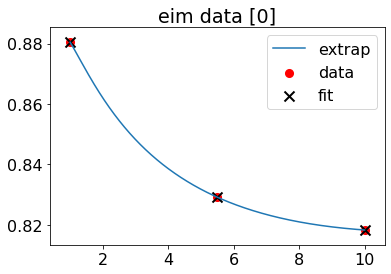

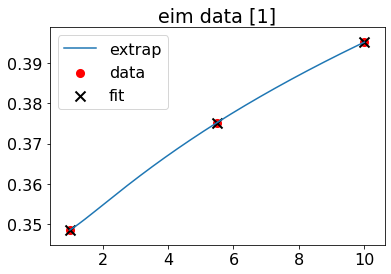

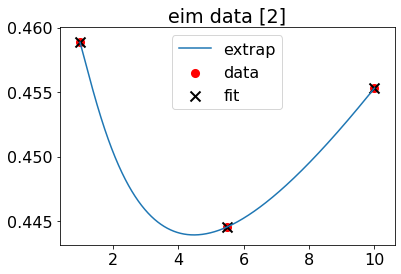

In [17]:
# fit_eim

X = sur.grb.greedy_points.copy()
X[:,0] = np.log(X[:,0])
y = sur.grb.eim.data

sur.fit_eim(X, y, method='lr', maxdegs=[4], max_deg_total=4)

In [18]:
sur.grb.nbasis

3

In [19]:
_, vts, _, vts_coords = gen_1d_massratio_data(np.random.uniform(1,10,100), 60) 

In [20]:
model_errors, worst_case, worst_error_index = sur.validate_surrogate(vts, vts_coords)
print(f"worst case = {worst_case}")

worst case = [1.90798217]


In [21]:
worst_case

array([1.90798217])

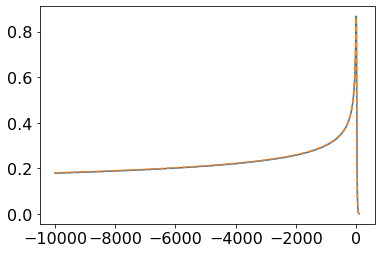

In [22]:
plt.figure()
plt.plot(seed_x, vts[worst_error_index])
plt.plot(seed_x, sur.predict([worst_case]), ls='--')

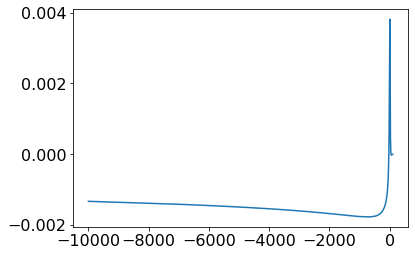

In [23]:
plt.figure()
plt.plot(seed_x, vts[worst_error_index] - sur.predict([worst_case]))

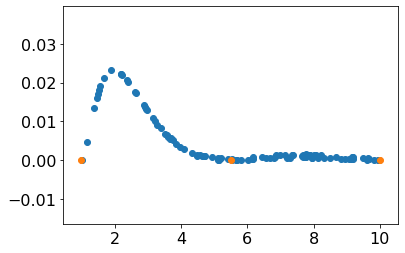

In [24]:
plt.figure()
plt.scatter(vts_coords, model_errors)
plt.scatter(sur.grb.greedy_points, np.zeros(len(sur.grb.greedy_points)))
plt.show()
plt.close()

In [25]:
vts_worst = vts[worst_error_index]
vts_coords_worst = vts_coords[worst_error_index]

In [26]:
# add the worst case to the basis and re-fit
sur.run_greedy_sweep(vts_worst.reshape(1,-1), vts_coords_worst.reshape(1, -1), greedy_tol=1e-7)

step = 0, error = 2.884669946507321e-05


In [27]:
sur.grb.nbasis 

4

In [28]:
# build eim
# eim needs to be built from training_set at the greedy points
_, ts, _, _ = gen_1d_massratio_data(sur.grb.greedy_points.ravel(), 60)

In [29]:
sur.build_eim(ts)

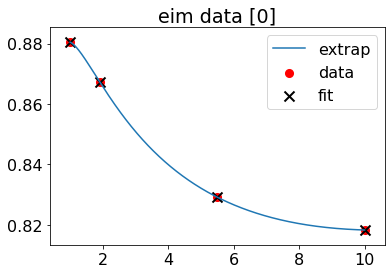

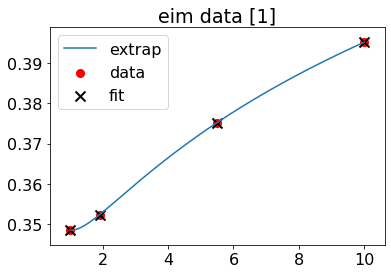

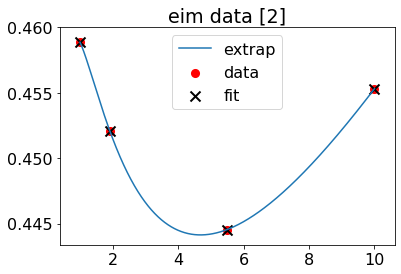

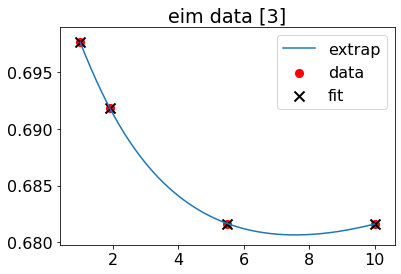

In [30]:
# fit_eim

X = sur.grb.greedy_points.copy()
X[:,0] = np.log(X[:,0])
y = sur.grb.eim.data

sur.fit_eim(X, y, method='lr', maxdegs=[4], max_deg_total=4)

In [31]:
for f in sur.fits:
    print(f.degrees)

[[0], [1], [2], [3]]
[[0], [1], [2], [3]]
[[0], [1], [2], [3]]
[[0], [1], [2], [3], [4]]


In [32]:
model_errors, worst_case, worst_error_index = sur.validate_surrogate(vts, vts_coords)
print(f"worst case = {worst_case}")

worst case = [7.77747621]


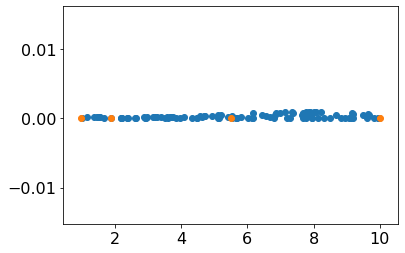

In [33]:
plt.figure()
plt.scatter(vts_coords, model_errors)
plt.scatter(sur.grb.greedy_points, np.zeros(len(sur.grb.greedy_points)))
plt.show()
plt.close()

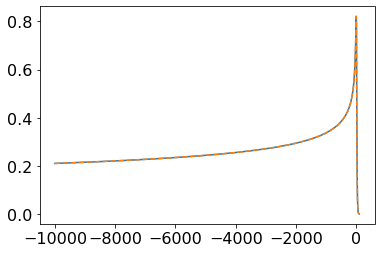

In [34]:
plt.figure()
plt.plot(seed_x, vts[worst_error_index])
plt.plot(seed_x, sur.predict([worst_case]), ls='--')

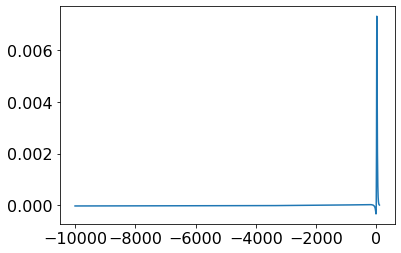

In [35]:
plt.figure()
plt.plot(seed_x, vts[worst_error_index] - sur.predict([worst_case]))